In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Syahrir Ridha\\PycharmProjects\\NET_Solver\\')
import numpy as np
import torch
from geometry import *
from utils import Plot_Grid
from solver import *
from models import *
from mesh import *
from boundary import *
import matplotlib.pyplot as plt
%matplotlib inline

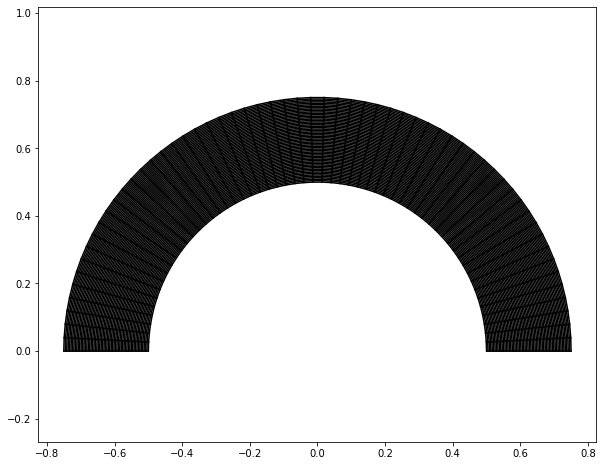

In [2]:
nx, ny = 60, 60
xi_, eta_ = torch.linspace(0,1,nx,requires_grad=True), torch.linspace(0,1,ny,requires_grad=True)
xi, eta = torch.meshgrid(xi_, eta_)
xi, eta = xi.reshape(-1,1), eta.reshape(-1,1)
anulus = Analytical_Annulus(0.75, 0.5, 0.)
grid = TFI(xi, eta, anulus)
Plot_Grid(grid.X().detach().numpy().reshape(nx,ny),grid.Y().detach().numpy().reshape(nx,ny),nx,ny)

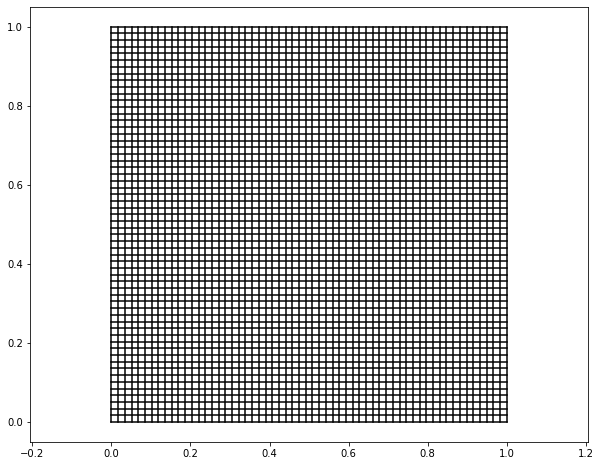

In [3]:
Plot_Grid(xi.detach().numpy().reshape(nx,ny),eta.detach().numpy().reshape(nx,ny),nx,ny)

In [4]:
# # sample function for correct seperation of computational variables
# def comp_data(data):
#     dxdxi = data[:,0]
#     dxdeta = data[:,1]
#     dydxi = data[:,2]
#     dydeta = data[:,3]
#     jac = data[:,4]
#     djdxi = data[:,5]
#     djdeta = data[:,6]
#     return dxdxi, dxdeta, dydxi, dydeta, jac, djdxi, djdeta

In [5]:
# code the governning equation
tau = 0.
n = 0.56
K = 1.74
dpdz = 0.34

class Gov_Eq(PDE):
    
    def PDELoss(self, inputs, outputs):
        
        # seperate the inputs
        xi, eta = inputs[:,0], inputs[:,1]
        
        # calculate the x and y coordinates
        grid = TFI(xi, eta, anulus)
        x, y = grid.X(), grid.Y()
        
        # calculate all the gradients
        dxdxi, dxdeta, dydxi, dydeta, jac = self.cal_grads(x, y, xi, eta)
        
        # calculate alpha, beta and gamma
        alpha = dxdeta**2 + dydeta**2
        gamma = dxdeta*dxdxi + dydeta*dydxi
        beta = dxdxi**2 + dydxi**2
        
        # output gradients
        out_grad = self.compute_grad(outputs, inputs)
        dudxi, dudeta = out_grad[:,0], out_grad[:,1]
        
        # compute the apparent viscosity
        _ua = self.HB_model(out_grad, x, y, xi, eta, tau, n, K)
        
        # code part (a)
        left = (_ua/jac)*(alpha*dudxi - gamma*dudeta)
        
        # code part(b)
        right = (_ua/jac)*(beta*dudeta - gamma*dudxi)
        
        # derivative of left and right
        left_xi = self.compute_grad(left, inputs)[:,0]
        
        right_eta = self.compute_grad(right, inputs)[:,1]
        
        # combine evverything
        gov_eq = (1/jac)*(left_xi + right_eta) + dpdz
        
        return {'PDE': gov_eq}
    
#     def HB_model(self, out_grad, x, y, xi, eta, n, k, tau):
#         shear = self.shear_rate(out_grad, x,y, xi, eta)
#         app_vis = (tau/shear) + (shear**(n-1))*k
#         return app_vis
    
     # define the modified apparent viscosity
    def HB_model(self, out_grad, x, y, xi, eta, n, k, tau, cs=0.1 ):
        
        # calculate the shear 
        shear = self.shear_rate_new(out_grad, x, y, xi, eta)
        
        # create a dummy vicosity
        vis = torch.zeros_like(shear)
        
        # mask the shear rate less than the crtial shear rate
        # mask for the body portion
        mask_body = shear>cs
        # mask for the boundary portion
        mask_bound = shear<= cs
        
        # create index for the body and boundary mask
        ind_body = torch.nonzero(mask_body).unsqueeze(1)
        ind_bound = torch.nonzero(mask_bound).unsqueeze(1)
        
        # calculate the modified apparent viscsity
        vis[ind_body] = (tau)/shear[ind_body] + ((shear[ind_body])**(n-1))*k
        vis[ind_bound] = tau*(2 - (shear[ind_bound]/cs))/cs + k * ( (2-n)+(n-1)* (shear[ind_bound]/cs))
        #vis[ind_bound] = (2/cs) + k*(2-n)
        #vis[ind_bound] = tau/cs + k*cs**(n-1)
        
        return vis
    
    def shear_rate_new(self, out_grad, x,y, xi, eta, tol=1e-2):
        #calcuate the cord grads
        dxdxi, dxdeta, dydxi, dydeta, jac = self.cal_grads(x,y,xi, eta)
        
        # output grads
        dudxi = out_grad[:,0]
        dudeta = out_grad[:,1]
        
        numerator = torch.zeros_like(dudxi)
        one_mask = (dudxi != 0)
        numerator[one_mask] = (1/jac[one_mask])*torch.sqrt((dydeta[one_mask]*dudxi[one_mask])**2 + (dxdxi[one_mask]*dudeta[one_mask])**2)
        y = (numerator)
        zero_mask = (dudxi ==0)
        y[zero_mask] = 0
        
        return y
    
    # define the shear rate
#     def shear_rate(self, out_grad, x,y, xi, eta, tol=1e-2):
#         # calcuate the cord grads
#         dxdxi, dxdeta, dydxi, dydeta, jac = self.cal_grads(x,y,xi, eta)
        
#         # output grads
#         dudxi = out_grad[:,0]
#         dudeta = out_grad[:,1]
        
#         # calculate the shear rate
#         shear_ = (1/jac)*((dydeta*(dudxi) - dydxi*(dudeta))**2 + (dxdxi*(dudeta) - dxdeta*(dudxi))**2)**(0.5)
        
#         # create mask
#         dummy_shear = torch.zeros_like(shear_)
#         mask = shear_ <=tol
#         indices = torch.nonzero(mask).unsqueeze(1)
#         dummy_shear[indices] = tol**2
#         shear = (1/jac)*((dydeta*(dudxi+dummy_shear) - dydxi*(dudeta+dummy_shear))**2 + (dxdxi*(dudeta+dummy_shear) - dxdeta*(dudxi+dummy_shear))**2)**(0.5)
        
#         return torch.abs_(shear)
        
    
    def cal_grads(self, x, y, xi, eta):
        # compute all the gradients wrt x,y 
        dxdxi = self.compute_grad(x, xi)
        dxdeta = self.compute_grad(x, eta)
        dydxi = self.compute_grad(y, xi)
        dydeta = self.compute_grad(y, eta)
        jac = dxdxi*dydeta - dxdeta*dydxi
        
        return dxdxi, dxdeta, dydxi, dydeta, jac
    
# initiate the PDE equation
pde = Gov_Eq(inputs=('xi', 'eta'), outputs='u')

pass


In [6]:
# define the meshing data
xi_m, eta_m = np.linspace(0,1,nx), np.linspace(0,1,ny)
mesh = Mesh({'xi':xi_m, 'eta':eta_m})
pde.set_mesh(mesh)

In [7]:
# # when u = 0 @ xi = 0,1
# xi_ = np.array([0,1])
# u_ = np.full(2*len(xi_m), 0)
# pipe = Dirichlet({'xi':xi_, 'eta':eta_m}, {'u':u_}, name='Pipe')
# pde.add_boundary(pipe)
def _init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, 1. / np.sqrt(y))
        m.bias.data.fill_(0)
class Trial_Solution:
    def __init__(self, model, boundary):
        self.model = model
        self.model.apply(_init_weights)
        self.var = tuple(boundary.keys())
        self.bound = list(boundary.values())
        
    def __call__(self,input_data):
        #x = input_data[:,0].reshape(-1,1)
        trial = (input_data[:,0].reshape(-1,1) )*(1-input_data[:,0].reshape(-1,1))*self.model(input_data)
        return (trial)

In [8]:
# when dudxi = 0 @ eta = 0,1
eta_ = np.array([0,1])
class Neumann(Neumann):
    def neumann_loss(self, inputs, outputs):
        dudeta = self.compute_grad(outputs, inputs)[:,1]
        return {'gradXi': dudeta}
outer = Neumann({'xi':xi_m, 'eta':eta_}, name='left_flank')
pde.add_boundary(outer)

In [9]:
# # implement hard boundary
# hd_b = Hard_Boundary(Dirichlet={'xi':xi_m,'eta':eta_}, Neumann={'xi':xi_, 'eta':eta_m})
# pde.hard_boundary(hd_b)

In [10]:
btach_size = 1000
lr = 0.001
epochs = 100
hid_dim = 200
layers = 7
in_dim = len(pde.input)
out_dim = len(pde.output)
activation = Sine()
#activation = torch.nn.Tanh()

net = MLP(in_dim, out_dim, layers, hid_dim, act=activation)
trial = Trial_Solution(net, {'xi_inn':0.0, 'xi_out':1.0})
#net.apply(_init_weights)

optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, pct_start=0.1, total_steps=epochs)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,cycle_momentum=True)

pde.compile(trial,optimizer, scheduler)

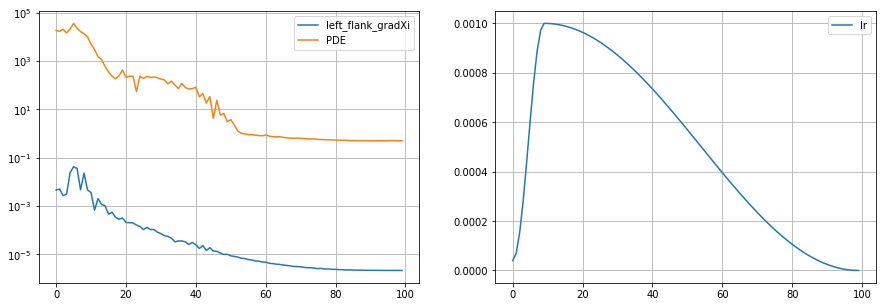

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


Wall time: 1min 33s


In [11]:
%time hist = pde.solve(epochs, btach_size)

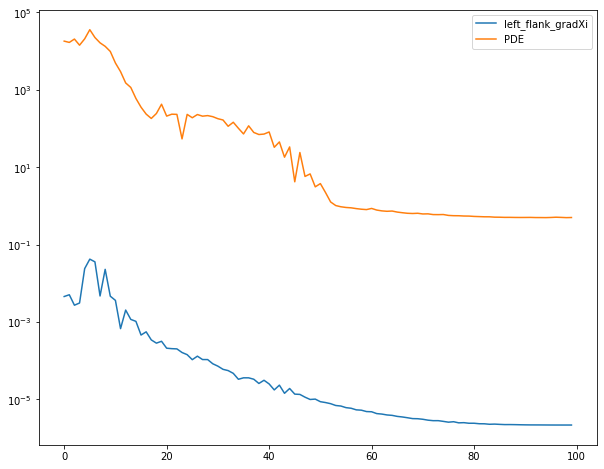

In [12]:
plt.figure(figsize=(10,8))
for key, value in hist.items():
    if key!= 'lr':
        plt.plot(hist[key],label=key)
        plt.legend()
    else:
        pass
    
    plt.yscale('log')

In [13]:
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)

eval_mesh = Mesh({'x':x, 'y':y})
#pred = pde.eval(eval_mesh).view(len(y),len(x)).numpy()
pred = trial(eval_mesh.gen_data[:]).view(len(y),len(x)).detach().numpy()

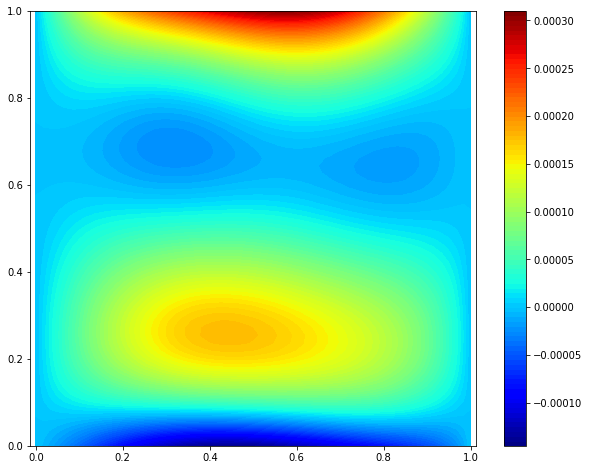

In [14]:
plt.figure(figsize=(10,8))
xx, yy = np.meshgrid(x,y)
plt.contourf(xx,yy, pred, 100, cmap='jet')
plt.colorbar()
plt.axis('equal');

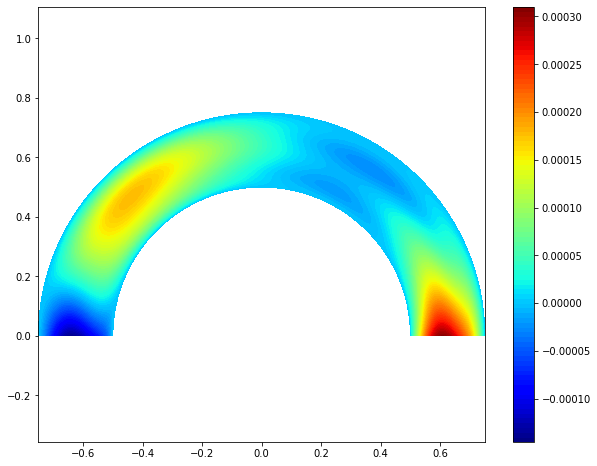

In [15]:
plt.figure(figsize=(10,8))
grid = TFI(torch.from_numpy(xx), torch.from_numpy(yy), anulus)
plt.contourf(grid.X().detach().numpy().reshape(nx,ny),grid.Y().detach().numpy().reshape(nx,ny), pred, 100, cmap='jet')
plt.colorbar()
plt.axis('equal');

In [16]:
from scipy.integrate import simps

In [17]:
#integrate.simps(integrate.simps(pred, x= x,axis=0),x=y)

In [18]:
simps([simps(zz_x,x) for zz_x in pred],y) *2

0.0001026974574954595

In [19]:
xx.ravel().shape

(3600,)

In [20]:
yy.ravel().shape

(3600,)

In [21]:
0/np.inf

0.0

In [22]:
np.exp(100)/0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


inf